Tables created :employees and departments

ROLAP result (SQL aggregation):
    department    avg_salary
0  Engineering  77500.000000
1           HR  93333.333333
2        Sales  60000.000000


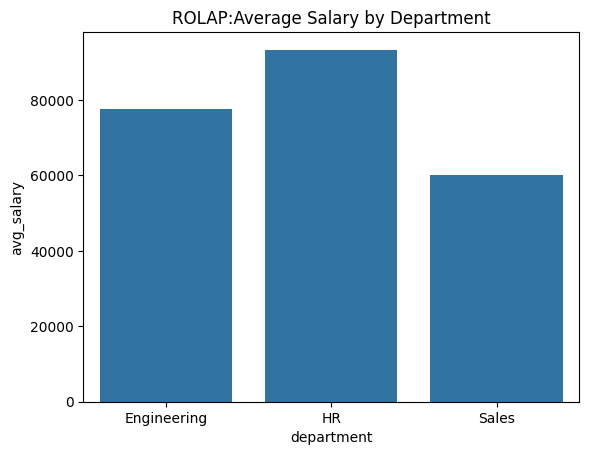


MOLAP Cube (Department vs Age):
age               28       30       32       35        40       45
dept_name                                                         
Engineering      0.0      0.0  75000.0  80000.0       0.0      0.0
HR               0.0  70000.0      0.0      0.0  120000.0  90000.0
Sales        60000.0      0.0      0.0      0.0       0.0      0.0


C:\Users\nyaga\AppData\Local\Temp\ipykernel_1412\1615176904.py:72: FutureWarning: The provided callable <function mean at 0x000001F40E140220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  molap_cube=pd.pivot_table(


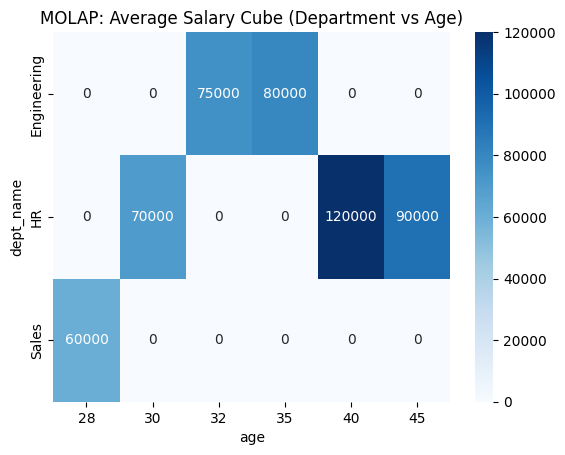


HOLAP Summary (Average Salary by Department):
     dept_name        salary
0  Engineering  77500.000000
1           HR  93333.333333
2        Sales  60000.000000


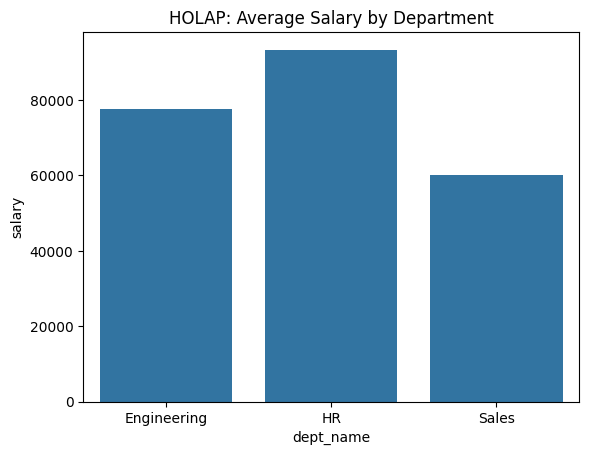


Slice (IT Department):
Empty DataFrame
Columns: [name, dept_name, salary]
Index: []

Dice (HR Department with Salary > 60000):
      name dept_name  salary
0    Alice        HR   70000
2  Charlie        HR  120000
5    Frank        HR   90000


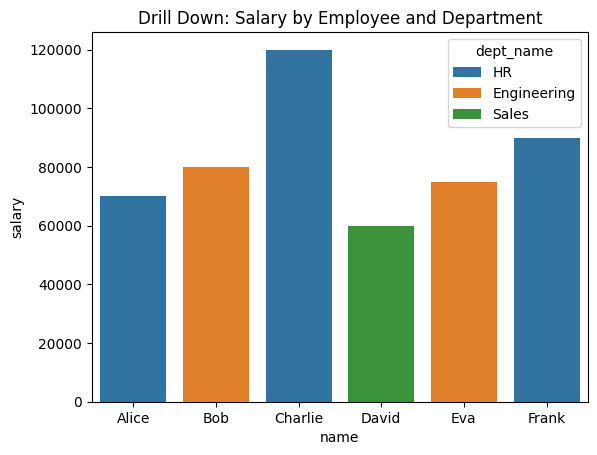


Roll Up (Total Salary by Department):
     dept_name  salary
0  Engineering  155000
1           HR  280000
2        Sales   60000


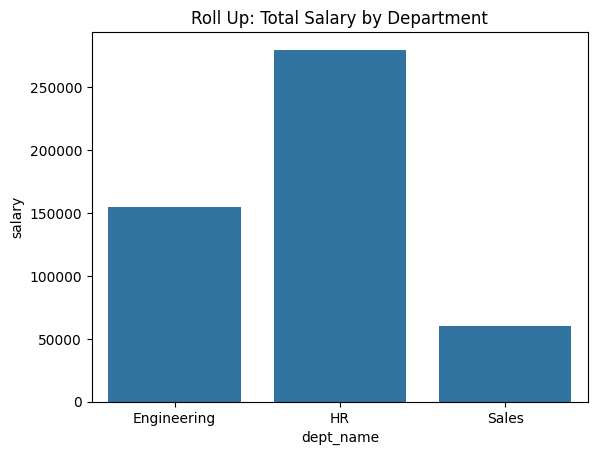

In [ ]:
#OLAP DEMO

# This script demonstrates basic OLAP operations using pandas.
#ROLAP ,MOLAP and HOLAP

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt



#database connection
def create_connection(db_file="olap_demo.db"):
    conn = sqlite3.connect(db_file)
    return conn


# Create a sample dataset

employees = pd.DataFrame({
    'emp_id': [1, 2, 3, 4, 5,6],
    'name': ['Alice', 'Bob', 'Charlie', 'David', 'Eva','Frank'],
    'age': [30, 35, 40, 28, 32,45],
    'salary': [70000, 80000, 120000, 60000, 75000,90000],
    'dept_id': [1, 2, 1, 3, 2,1]
})

departments = pd.DataFrame({
    'dept_id': [1, 2, 3],
    'dept_name': ['HR', 'Engineering', 'Sales'] 

})


#load data into sqlite database

conn=create_connection()
employees.to_sql('employees', conn, if_exists='replace', index=False)
departments.to_sql('departments', conn, if_exists='replace', index=False)

print("Tables created :employees and departments")
    

# Perform OLAP operations

#ROLAP Operations
query = """
SELECT d.dept_name as department, AVG(e.salary) as avg_salary
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
GROUP BY d.dept_name

"""


rolap_result = pd.read_sql_query(query, conn)
print("\nROLAP result (SQL aggregation):")
print(rolap_result)


#VISUALIZATION :Roll up by department
sns.barplot(data=rolap_result, x='department', y='avg_salary')
plt.title("ROLAP:Average Salary by Department")
plt.show()


#MOLAP Operations
# Using pandas for in-memory aggregation

molap_cube=pd.pivot_table(

    employees.merge(departments, on='dept_id'),
    values='salary',
    index='dept_name',
    columns='age',
    aggfunc=np.mean,
    fill_value=0
)
print("\nMOLAP Cube (Department vs Age):")
print(molap_cube)

#VISUALIZATION :MOLAP cube heatmap
sns.heatmap(molap_cube, annot=True, fmt=".0f", cmap="Blues")
plt.title("MOLAP: Average Salary Cube (Department vs Age)")
plt.show()



#HOLAP Operations
# Combining ROLAP and MOLAP approaches

detail_sql = """
SELECT e.name, d.dept_name, e.salary
FROM employees e
JOIN departments d ON e.dept_id = d.dept_id
"""
detail_df = pd.read_sql_query(detail_sql, conn)

#pandas MOLAP aggregation
holap_summary=detail_df.groupby('dept_name')['salary'].mean().reset_index()

print("\nHOLAP Summary (Average Salary by Department):")
print(holap_summary)

#visualization :HOLAP summary
sns.barplot(data=holap_summary, x='dept_name', y='salary')
plt.title("HOLAP: Average Salary by Department")
plt.show()


#OLAP operations demonstrated: ROLAP, MOLAP, HOLAP

#slice
slice_df=detail_df[detail_df['dept_name']=='IT']
print("\nSlice (IT Department):")
print(slice_df)


#dice
dice_df=detail_df[(detail_df['dept_name']=='HR') & (detail_df['salary']>60000)]
print("\nDice (HR Department with Salary > 60000):")
print(dice_df)


#drill down

sns.barplot(data=detail_df, x='name', y='salary', hue='dept_name')
plt.title("Drill Down: Salary by Employee and Department")
plt.show()



#rollup
rollup_df=detail_df.groupby('dept_name')['salary'].sum().reset_index()
print("\nRoll Up (Total Salary by Department):")
print(rollup_df)

#visualization :rollup
sns.barplot(data=rollup_df, x='dept_name', y='salary')
plt.title("Roll Up: Total Salary by Department")
plt.show()

# Close the database connection
conn.close()